# Spatial Mapping

## Table of Contents

1. [Introduction](#1.-Introduction)
2. [Convert Model Predictions to Spatial Data](#2.-Convert-Model-Predictions-to-Spatial-Data)
3. [Validate the Suitability Maps](#3.-Validate-the-Suitability-Maps)

## 1. Introduction

The final stage of species distribution modelling involves translating model outputs into spatially explicit predictions for visualization and analysis in Geographic Information Systems (GIS). This step is crucial for identifying suitable habitats, informing conservation planning, and integrating results into decision-making frameworks.

Species distribution models (SDMs) generate probability estimates of species presence based on environmental predictors. These probabilities must be converted into spatially explicit rasters or vector layers that align with the study area’s geographic coordinates. The transition from tabular predictions to spatial datasets ensures that results can be integrated with other environmental data, such as land cover, habitat connectivity, and conservation priorities.

The goal is to predict species suitability across a continuous landscape using environmental predictors. This is typically achieved by applying trained models to these predictors to generate continuous suitability maps.

### Interpolation vs. Model Application:

1. **Model Application**: After training the models (e.g., Random Forest, XGBoost, MaxEnt) using occurrence data and environmental predictors, these trained models can be applied to the same set of predictors across the entire study area. This process generates continuous suitability values for each location, resulting in a comprehensive suitability map.

2. **Interpolation:** Interpolation methods, such as kriging, estimate values at unsampled locations based on the spatial configuration of sampled points. While interpolation can be useful in certain contexts, it doesn't leverage the relationship between species occurrences and environmental predictors as effectively as direct model application.

## 2. Create Suitability Maps

To create continuous suitability maps we will:
1. **Prepare Environmental Predictors**: Ensure all environmental predictor rasters are aligned (same resolution, extent, and coordinate system).
2. **Apply Trained Models**: Use the trained ensemble model to predict suitability values across the entire study area by applying it to the predictor rasters.
3. **Generate Suitability Maps**: The output will be continuous suitability maps indicating the predicted probability of species presence for each location.

### **Load Final Suitability Predictions**

In [1]:
import os
import pandas as pd
import geopandas as gpd

# Define paths
prediction_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Models\Final_Binary"
species_list = ["Bufo bufo", "Rana temporaria", "Lissotriton helveticus"]

# Load prediction files
predictions = {}
for species in species_list:
    file_path = os.path.join(prediction_dir, f"{species}_Final_Binary_Predictions.csv")
    if os.path.exists(file_path):
        predictions[species] = pd.read_csv(file_path)
        print(f"✅ Loaded predictions for {species}")
    else:
        print(f"⚠️ Missing predictions for {species}")


✅ Loaded predictions for Bufo bufo
✅ Loaded predictions for Rana temporaria
✅ Loaded predictions for Lissotriton helveticus


### **Stack Predictors into a Multi-Band Raster**

### Check Raster Shapes Before Stacking

In [3]:
import rasterio

# Define predictor raster file paths
predictor_files = [
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMoisture_32bit_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Wood_Resample_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Grass_Stand.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/NDVI_median.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/NDVI_StDev.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/VegHeight.tif"
]

# Check raster shapes
for file in predictor_files:
    with rasterio.open(file) as src:
        print(f"{file}: {src.shape}, Resolution: {src.res}, CRS: {src.crs}")


C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif: (5970, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif: (5971, 6369), Resolution: (30.0, 30.0), CRS: EPSG:27700
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMo

### Reproject and Resample to Match a Reference Raster

In [4]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

# Choose a reference raster (first predictor)
reference_raster = predictor_files[0]

# Define output directory for resampled rasters
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled"
os.makedirs(output_dir, exist_ok=True)

# Open reference raster
with rasterio.open(reference_raster) as ref_src:
    ref_transform = ref_src.transform
    ref_width = ref_src.width
    ref_height = ref_src.height
    ref_crs = ref_src.crs

# Resample and reproject other rasters to match reference
for file in predictor_files:
    output_file = os.path.join(output_dir, os.path.basename(file))

    with rasterio.open(file) as src:
        if (src.shape != (ref_height, ref_width)) or (src.crs != ref_crs):
            print(f"🔄 Resampling {file}...")

            # Calculate new transform and dimensions
            transform, width, height = calculate_default_transform(
                src.crs, ref_crs, src.width, src.height, *src.bounds
            )

            # Update metadata
            new_meta = src.meta.copy()
            new_meta.update({
                "crs": ref_crs,
                "transform": transform,
                "width": ref_width,
                "height": ref_height
            })

            # Create resampled raster
            with rasterio.open(output_file, "w", **new_meta) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=ref_crs,
                        resampling=Resampling.bilinear  # Use bilinear resampling
                    )

            print(f"✅ Resampled and saved: {output_file}")
        else:
            print(f"✅ {file} already matches reference raster.")

print("\n🚀 Resampling complete! Use these resampled rasters for stacking.")


✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif already matches reference raster.
✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif already matches reference raster.
✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif already matches reference raster.
✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif already matches reference raster.
🔄 Resampling C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif...
✅ Resampled and saved: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled\Runoff_Coefficient_Standardised_Reversed.tif
✅ C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif already matches reference raster.
🔄 Resampling C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMo

### Create a List of the Correct File Paths

In [6]:
import os

# Define original predictor file paths
original_predictor_files = [
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMoisture_32bit_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Wood_Resample_Reversed.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Grass_Stand.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/NDVI_median.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/NDVI_StDev.tif",
    "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/VegHeight.tif"
]

# Define resampled directory
resampled_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled"

# Generate final paths: use resampled files if they exist, otherwise use original
final_predictor_files = []
for file in original_predictor_files:
    resampled_path = os.path.join(resampled_dir, os.path.basename(file))
    
    if os.path.exists(resampled_path):  # Use resampled version if available
        final_predictor_files.append(resampled_path)
    else:  # Use original file
        final_predictor_files.append(file)

# Print final list to check
for file in final_predictor_files:
    print(f"✅ Using: {file}")


✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled\Runoff_Coefficient_Standardised_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Resampled\SoilMoisture_32bit_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Wood_Resample_Reversed.tif
✅ Using: C:/GIS_Course/MScThesis-MaviSantarelli/data/Pred

### Stack Resampled Rasters

In [11]:
import rasterio
import numpy as np

# Read and stack all predictors
stacked_data = []
meta = None

for i, file in enumerate(final_predictor_files):
    with rasterio.open(file) as src:
        if meta is None:
            meta = src.meta.copy()  # Save metadata from first raster
        data = src.read(1)  # Read the first band
        stacked_data.append(data)

# Convert to numpy array
stacked_array = np.stack(stacked_data, axis=0)

# Check stacked raster shape
print(f"✅ Stacked raster shape: {stacked_array.shape}")

# Save the stacked raster
meta.update(count=len(stacked_data), dtype=rasterio.float32)

with rasterio.open(stacked_raster_path, "w", **meta) as dst:
    dst.write(stacked_array.astype(rasterio.float32))

print(f"✅ Stacked raster saved at: {stacked_raster_path}")


✅ Stacked raster shape: (13, 5971, 6369)
✅ Stacked raster saved at: C:\GIS_Course\MScThesis-MaviSantarelli\data\Predictors\Stacked_Predictors.tif


### **Convert Raster to Model Input Format**

In [8]:
import pandas as pd

# Reshape raster stack into a 2D table (num_pixels, num_predictors)
num_bands, height, width = stacked_array.shape
reshaped_array = stacked_array.reshape(num_bands, -1).T  # Transpose to (num_pixels, num_predictors)

# Convert to DataFrame
predictor_df = pd.DataFrame(reshaped_array, columns=[f"Predictor_{i+1}" for i in range(num_bands)])

# Check for missing values
print(f"✅ Predictor DataFrame Shape: {predictor_df.shape}")
print(f"🔍 Missing Values:\n{predictor_df.isnull().sum()}")

# Drop rows with NaN values (if any)
predictor_df = predictor_df.dropna().reset_index(drop=True)
print(f"✅ Cleaned Predictor DataFrame Shape: {predictor_df.shape}")


✅ Predictor DataFrame Shape: (38029299, 13)
🔍 Missing Values:
Predictor_1     0
Predictor_2     0
Predictor_3     0
Predictor_4     0
Predictor_5     0
Predictor_6     0
Predictor_7     0
Predictor_8     0
Predictor_9     0
Predictor_10    0
Predictor_11    0
Predictor_12    0
Predictor_13    0
dtype: int64
✅ Cleaned Predictor DataFrame Shape: (38029299, 13)


### **Apply Ensemble Model to Generate Suitability Scores**

In [37]:
class WeightedEnsembleModel:
    """
    Weighted ensemble model for species distribution predictions.
    Uses weighted averaging based on model performance metrics.
    """
    def __init__(self, weights):
        self.weights = weights  # Store weights for each model (RF, XGBoost, MaxEnt)

    def predict(self, X):
        """
        Compute weighted ensemble predictions.
        :param X: DataFrame containing model probabilities (RF, XGBoost, MaxEnt).
        :return: Weighted probability scores.
        """
        weighted_pred = np.zeros(len(X))
        for model in self.weights.keys():
            if model in X.columns:
                weighted_pred += X[model] * self.weights[model]
            else:
                print(f"⚠️ Warning: {model} not found in input data.")
        return weighted_pred

In [42]:
import os
import rasterio
import numpy as np
import joblib
import pandas as pd

# Define file paths
stacked_raster_path = r"C:\GIS_Course\MScThesis-MaviSantarelli\data\Predictors\Stacked_Predictors.tif"
model_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Models\Weighted_Ensemble"
output_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps"
os.makedirs(output_dir, exist_ok=True)

# Define species list
species_list = ["Bufo bufo", "Rana temporaria", "Lissotriton helveticus"]

# Load stacked raster
with rasterio.open(stacked_raster_path) as src:
    stacked_data = src.read()  # Shape: (num_predictors, height, width)
    meta = src.meta.copy()
    height, width = src.shape
    num_pixels = height * width  # Total number of pixels

    # Reshape raster data to match ML model input
    num_predictors = stacked_data.shape[0]  # Number of predictors
    flat_data = stacked_data.reshape(num_predictors, -1).T  # Shape: (num_pixels, num_predictors)

    # Convert to DataFrame
    predictor_df = pd.DataFrame(flat_data, columns=[f"Predictor_{i}" for i in range(num_predictors)])

# Iterate over species
for species in species_list:
    print(f"🔍 Generating suitability map for {species}...")

    # Load trained ensemble model
    model_path = os.path.join(model_dir, f"{species}_Final_Ensemble_Model.pkl")
    
    if not os.path.exists(model_path):
        print(f"⚠️ Missing model for {species}. Skipping.")
        continue

    ensemble_model = joblib.load(model_path)  # Load saved model object

    # Ensure the model has a predict function
    if not hasattr(ensemble_model, "predict"):
        print(f"⚠️ Loaded model for {species} does not have a predict function. Skipping.")
        continue

    # Apply ensemble model to generate suitability scores
    suitability_scores = ensemble_model.predict(predictor_df)

    # Ensure suitability scores match expected raster shape
    if suitability_scores.shape[0] != num_pixels:
        print(f"⚠️ Mismatch: Prediction data has {suitability_scores.shape[0]} rows, expected {num_pixels}. Skipping {species}.")
        continue

    # Reshape back to raster dimensions
    suitability_map = suitability_scores.reshape(height, width)

    # Save suitability map
    meta.update(dtype=rasterio.float32, count=1)  # Update metadata
    output_file = os.path.join(output_dir, f"{species}_Suitability_Map.tif")

    with rasterio.open(output_file, "w", **meta) as dst:
        dst.write(suitability_map.astype(np.float32), 1)

    print(f"✅ Suitability map saved: {output_file}")

print("\n🚀 Suitability maps generated! Ready for threshold selection and connectivity analysis.")


🔍 Generating suitability map for Bufo bufo...
⚠️ Warning: RF not found in input data.
⚠️ Warning: XGBoost not found in input data.
⚠️ Warning: MaxEnt not found in input data.
✅ Suitability map saved: C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Bufo bufo_Suitability_Map.tif
🔍 Generating suitability map for Rana temporaria...
⚠️ Warning: RF not found in input data.
⚠️ Warning: XGBoost not found in input data.
⚠️ Warning: MaxEnt not found in input data.
✅ Suitability map saved: C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Rana temporaria_Suitability_Map.tif
🔍 Generating suitability map for Lissotriton helveticus...
⚠️ Warning: RF not found in input data.
⚠️ Warning: XGBoost not found in input data.
⚠️ Warning: MaxEnt not found in input data.
✅ Suitability map saved: C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps\Lissotriton helveticus_Suitability_Map.tif

🚀 Suitability maps generated! Ready for threshold selection and connectivity an

## 3. Validate the Suitability Maps

### **Load & Check Suitability Maps**

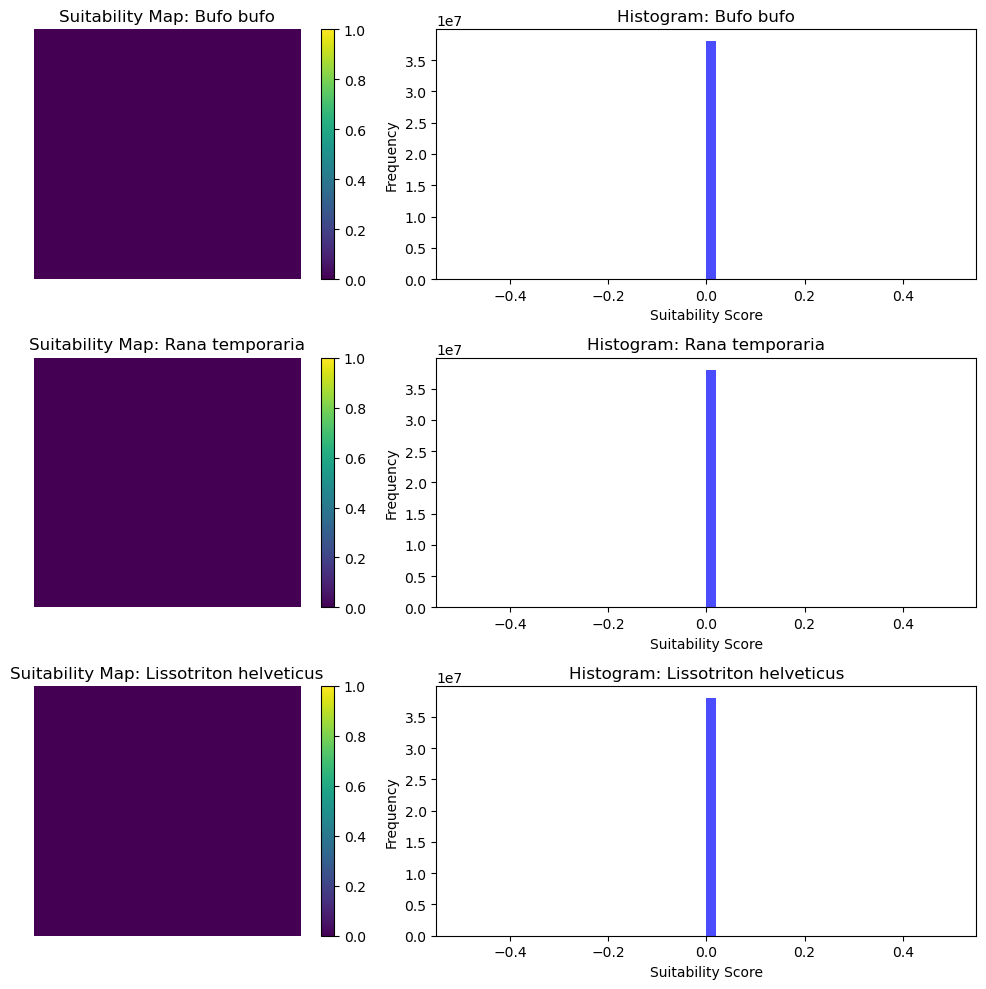

In [22]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

# Define paths to suitability maps
suitability_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Suitability_Maps"
species_list = ["Bufo bufo", "Rana temporaria", "Lissotriton helveticus"]

# Create subplots
fig, axes = plt.subplots(nrows=len(species_list), ncols=2, figsize=(12, 10))

# Iterate through each species
for i, species in enumerate(species_list):
    file_path = os.path.join(suitability_dir, f"{species}_Suitability_Map.tif")

    if not os.path.exists(file_path):
        print(f"⚠️ Missing suitability map for {species}. Skipping.")
        continue

    # Load raster
    with rasterio.open(file_path) as src:
        suitability_data = src.read(1)  # Read first band
        meta = src.meta.copy()

    # Plot raster map
    ax1 = axes[i, 0]
    img = ax1.imshow(suitability_data, cmap="viridis", vmin=0, vmax=1)
    ax1.set_title(f"Suitability Map: {species}")
    ax1.axis("off")
    fig.colorbar(img, ax=ax1, fraction=0.046, pad=0.04)

    # Plot histogram
    ax2 = axes[i, 1]
    ax2.hist(suitability_data.ravel(), bins=50, color='blue', alpha=0.7)
    ax2.set_title(f"Histogram: {species}")
    ax2.set_xlabel("Suitability Score")
    ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [25]:
import joblib
import os

# Define paths
model_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Models\Weighted_Ensemble"
species = "Bufo bufo"
model_path = os.path.join(model_dir, f"{species}_Final_Ensemble_Model.pkl")

# Load the saved model
ensemble_model = joblib.load(model_path)

# Print object type and attributes
print(f"🔍 Loaded model type: {type(ensemble_model)}")
print(f"🔍 Model attributes: {dir(ensemble_model)}")


🔍 Loaded model type: <class '__main__.WeightedEnsembleModel'>
🔍 Model attributes: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'predict', 'weights']


In [32]:
import joblib
import numpy as np
import pandas as pd
import os

# Define paths
model_dir = r"C:\GIS_Course\MScThesis-MaviSantarelli\results\Models\Weighted_Ensemble"
species = "Bufo bufo"
model_path = os.path.join(model_dir, f"{species}_Final_Ensemble_Model.pkl")

print("🔍 Model weights:", ensemble_model.weights)

print("🔍 Predictor Data Sample:\n", predictor_df.head())
print("🔍 Predictor Data Summary:\n", predictor_df.describe())
predictions = ensemble_model.predict(predictor_df)


if not os.path.exists(model_path):
    print(f"⚠️ Model for {species} is missing.")
else:
    # Load the saved ensemble model
    ensemble_model = joblib.load(model_path)

    # Generate test input (100 samples, 13 predictors)
    num_predictors = 13  
    test_data = np.random.rand(100, num_predictors)

    # Convert to DataFrame
    predictor_df = pd.DataFrame(test_data, columns=[f"Predictor_{i}" for i in range(num_predictors)])

    # Apply the function directly (since it is not a scikit-learn model)
    # Apply the ensemble model correctly
    predictions = ensemble_model.predict(predictor_df)  # ✅ Use .predict()


    print(f"Predictions for {species}:")
   # Print a few predictions to see if they are all zeros
    print("Predictions Sample:", predictions[:20])
    print("Min Prediction:", predictions.min(), "Max Prediction:", predictions.max())



🔍 Model weights: {'RF': 0.3829697098072442, 'XGBoost': 0.3484431264562593, 'MaxEnt': 0.26858716373649655}
🔍 Predictor Data Sample:
    Predictor_0  Predictor_1  Predictor_2  Predictor_3  Predictor_4  \
0     0.864656     0.639893     0.024413     0.349370     0.359375   
1     0.270960     0.267800     0.860191     0.115849     0.730797   
2     0.464631     0.990262     0.120338     0.284701     0.227331   
3     0.697606     0.997986     0.157122     0.528283     0.590665   
4     0.421264     0.074499     0.949500     0.758505     0.638966   

   Predictor_5  Predictor_6  Predictor_7  Predictor_8  Predictor_9  \
0     0.843827     0.281043     0.250770     0.950815     0.731428   
1     0.470211     0.527944     0.983323     0.101311     0.235311   
2     0.548647     0.460123     0.623756     0.503413     0.818226   
3     0.719879     0.249594     0.045347     0.992782     0.387276   
4     0.235861     0.812391     0.065192     0.591547     0.776550   

   Predictor_10  Predictor

In [33]:
print("🔍 Model predict function:\n", ensemble_model.predict)

🔍 Model predict function:
 <bound method WeightedEnsembleModel.predict of <__main__.WeightedEnsembleModel object at 0x00000206AE606C70>>


In [34]:
print("🔍 Model Weights:", ensemble_model.weights)

test_sample = predictor_df.head(5)  # Take 5 sample rows
print("🔍 Sample Input Data:\n", test_sample)

# Try predicting a small batch and print the output
predictions = ensemble_model.predict(test_sample)
print("🔍 Sample Predictions:", predictions)
print("🔍 Min Prediction:", np.min(predictions), "Max Prediction:", np.max(predictions))


🔍 Model Weights: {'RF': 0.3829697098072442, 'XGBoost': 0.3484431264562593, 'MaxEnt': 0.26858716373649655}
🔍 Sample Input Data:
    Predictor_0  Predictor_1  Predictor_2  Predictor_3  Predictor_4  \
0     0.812445     0.264777     0.941662     0.623194     0.042579   
1     0.889225     0.753153     0.702271     0.499608     0.298043   
2     0.763120     0.736726     0.502541     0.507843     0.106506   
3     0.252928     0.395915     0.940399     0.374087     0.030066   
4     0.060719     0.898183     0.610812     0.151033     0.287372   

   Predictor_5  Predictor_6  Predictor_7  Predictor_8  Predictor_9  \
0     0.456672     0.998851     0.745429     0.938119     0.172289   
1     0.195003     0.196896     0.034930     0.224284     0.997213   
2     0.647913     0.850735     0.251678     0.654066     0.893786   
3     0.095015     0.267725     0.357034     0.186058     0.317065   
4     0.717744     0.645331     0.177273     0.298432     0.162398   

   Predictor_10  Predictor_11 